<a href="https://colab.research.google.com/github/aettikang/bigdata_analysis_basic/blob/main/Eigenface%EC%99%80_%EC%96%BC%EA%B5%B4_%EC%82%AC%EC%A7%84_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eigenface를 이용한 차원 축소와 SVM을 이용한 분류

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2021)

## 1. Data

### 1.1 Data Load

데이터는 `sklearn.datasets`의 `fetch_lfw_people`로 받을 수 있습니다.

In [ ]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [ ]:
data, target = faces["data"], faces["target"]

### 1.2 Data EDA

이미지의 height와 width를 확인하면 다음과 같습니다.

In [ ]:
n_samples, h, w = faces.images.shape

In [ ]:
n_samples, h, w

(1288, 50, 37)

얼굴의 주인들의 이름을 확인해 보겠습니다.

In [ ]:
target_names = faces.target_names
n_classes = target_names.shape[0]

In [ ]:
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

이미지를 실제로 확인해 보겠습니다.

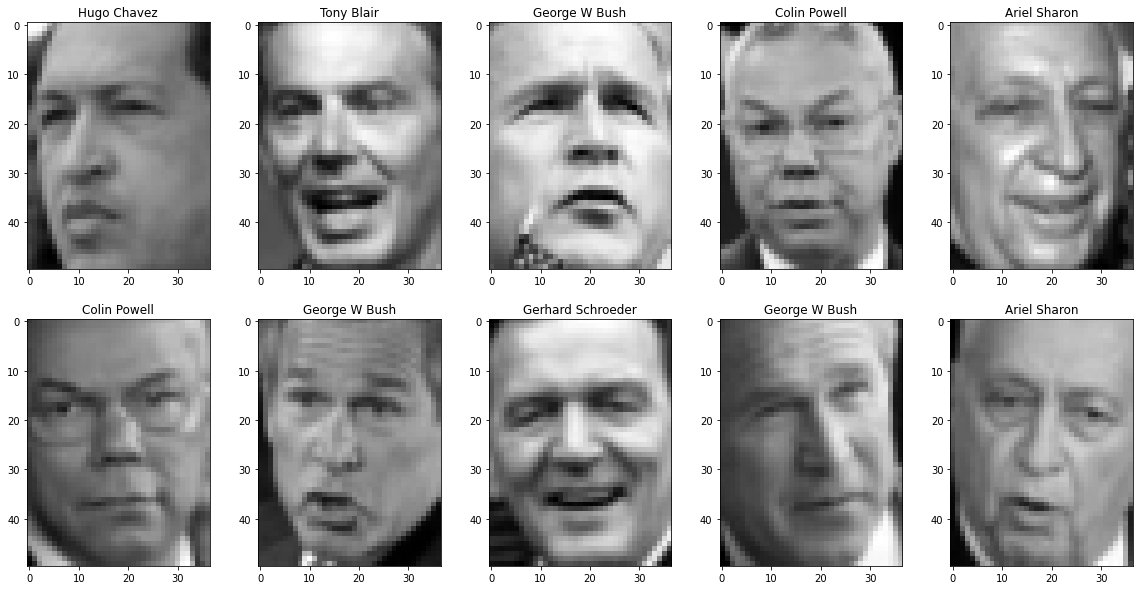

In [ ]:
samples = data[:10].reshape(10, h, w)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for idx, sample in enumerate(samples):
    ax = axes[idx//5, idx%5]
    ax.imshow(sample, cmap="gray")
    ax.set_title(target_names[target[idx]])

### 1.3 Data Split

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(
    data, target, train_size=0.7, random_state=2021
)

In [ ]:
print(f"train_data size: {len(train_target)}, {len(train_target)/len(data):.2f}")
print(f"test_data size: {len(test_target)}, {len(test_target)/len(data):.2f}")

train_data size: 901, 0.70
test_data size: 387, 0.30


### 1.4 Data Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
scaler.fit(train_data)

StandardScaler()

In [ ]:
scaled_train_data = scaler.transform(train_data)
scaled_test_data = scaler.transform(test_data)

## 2. Eigenface 

Eigenface란 PCA를 이용해 얼굴 사진을 축소하면 생기는 eigenvector가 얼굴 모양과 같다고 하여서 생긴 용어입니다.  
직접 실습을 통해 Eigenface를 생성해 보겠습니다.

### 2.1 학습

PCA를 이용해 데이터를 압축하겠습니다.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()

In [ ]:
pca.fit(scaled_train_data)

PCA()

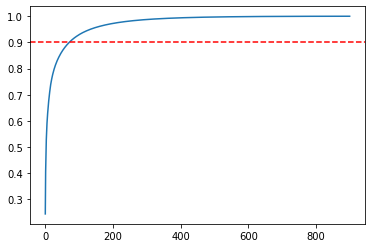

In [ ]:
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axhline(0.9, color="red", linestyle="--")

explained variance ratio가 0.9가 되는 지점의 component를 사용하겠습니다.

In [ ]:
pca = PCA(n_components=0.9)
pca.fit(scaled_train_data)

PCA(n_components=0.9)

In [ ]:
pca_train_data = pca.transform(scaled_train_data)
pca_test_data = pca.transform(scaled_test_data)

### 2.2 시각화

pca로 학습한 eigen vector를 시각화 해보겠습니다.  
PCA를 통해 다음 eigen vector에 나오는 얼굴의 특징을 추출한다고 생각할 수 있습니다.

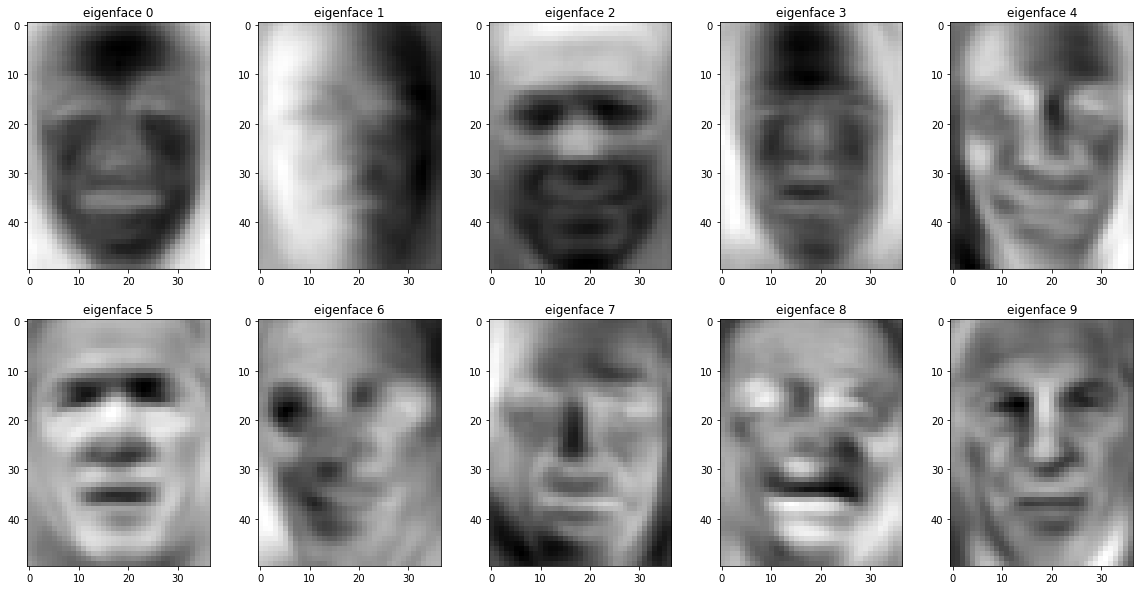

In [ ]:
eigenfaces = pca.components_.reshape((pca.n_components_, h, w))
samples = eigenfaces[:10].reshape(10, h, w)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for idx, sample in enumerate(samples):
    ax = axes[idx//5, idx%5]
    ax.imshow(sample, cmap="gray")
    ax.set_title(f"eigenface {idx}")

## 3. SVM

### 3.1 Raw Data

우선 앞선 SVM 실습에서 진행했던 Baseline의 결과를 보겠습니다.

In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(scaled_train_data, train_target)

SVC()

In [ ]:
train_pred = svm.predict(scaled_train_data)
test_pred = svm.predict(scaled_test_data)

In [ ]:
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(train_target, train_pred)
test_acc = accuracy_score(test_target, test_pred)

In [ ]:
print(f"train accuracy is {train_acc:.4f}")
print(f"test accuracy is {test_acc:.4f}")

train accuracy is 0.9567
test accuracy is 0.7339


### 3.2 Eigenface

이번에는 Eigenface로 추출된 특징만으로 SVM을 학습시킨 후 결과를 보겠습니다.

In [ ]:
eigenface_svm = SVC()
eigenface_svm.fit(pca_train_data, train_target)

SVC()

In [ ]:
pca_train_pred = eigenface_svm.predict(pca_train_data)
pca_test_pred = eigenface_svm.predict(pca_test_data)

In [ ]:
pca_train_acc = accuracy_score(train_target, pca_train_pred)
pca_test_acc = accuracy_score(test_target, pca_test_pred)

In [ ]:
print(f"Eigenface train accuracy is {pca_train_acc:.4f}")
print(f"Eigenface test accuracy is {pca_test_acc:.4f}")

Eigenface train accuracy is 0.9390
Eigenface test accuracy is 0.7364


## 4. 마무리

In [ ]:
train_data.shape

(901, 1850)

In [ ]:
pca_train_data.shape

(901, 72)

In [ ]:
print(f"Baseline test accuracy is {test_acc:.4f}")
print(f"Eigenface test accuracy is {pca_test_acc:.4f}")

Baseline test accuracy is 0.7339
Eigenface test accuracy is 0.7364
